# Locality Sensitive Hashing (LSH) from Scratch

Locality Sensitive Hashing (LSH) is a cornerstone technique for **approximate nearest‑neighbor search** at industrial scale.  
It powers similarity search at companies like Google, Netflix, Amazon, and Spotify, allowing them to surface recommendations in milliseconds over **billions** of vectors.


**Credits**

The following tutorial is adapted from [Locality Sensitive Hashing (LSH): The Illustrated Guide by Pinecone](https://www.pinecone.io/learn/series/faiss/locality-sensitive-hashing/).


**Compatibility**

| Platform                     | Compatible | Recommended | Notes                                                                                                                                                         |
| ---------------------------- | ---------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Local (e.g., M1 MacBook)** | ✅ Yes      | ✅ Yes       | -  |
| **Google Colab**             | ✅ Yes      | ✅ Yes       | If the images are not showing, you can download them from the course repository. |
| **Midway3 Login Node**       | ✅ Yes      | ✅ Yes       | - |
| **Midway3 Compute Node**     | ✅ Yes      | ✅ Yes      | -  |



## Why LSH? <a name="Search-Complexity"></a>

For a dataset of $n$ vectors, _exhaustive_ similarity search is

- **O(n)** for a single query
- **O(n²)** to find _all_ similar pairs

With modern datasets reaching _billions_ of items this is infeasible.  
The remedy is **approximate** search: accept a tiny error in exchange for sub‑linear runtime.

Locality Sensitive Hashing achieves this by hashing similar objects to the **same bucket** with high probability.


## How to build an LSH pipeline? <a name="Locality-Sensitive-Hashing"></a>

LSH is a family of hash functions with the property that **similar inputs collide more often** than dissimilar ones. In this tutorial, we will walk through the pipeline of applying LSH to find similar documents:


  1. **k‑Shingling**: represent each sentence/document with a set of n‑grams.
  2. **One-hot encoding**: represent each document as a binary vector with the same length as the vocabulary.
  2. **MinHash**: compress sparse vectors into short "signatures" that preserve Jaccard similarity.
  3. **Band and hash**: split signatures into bands and hash each band. We will implement the hand-hash technique from scratch, and then tune the _band_ parameter \(b\) to balance precision and recall.
  4. **Evaluation**: identity candidate similar pairs and evaluate the quality on a real dataset.

### Step 1: k‑Shingling <a name="k-Shingling"></a>

A _shingle_ is a contiguous sequence of `k` characters (equivalant to n-grams where $n=k$). **Sliding a window** of length `k` over a string yields a **set** (duplicates removed) of shingles.

<video width="640" height="360" autoplay loop muted>
  <source src="assets/locality-sensitive-hashing-5.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>


For $k=5$ we have:

`"flying fish"` -> `['flyin', 'lying', 'ying ', 'ing f', 'ng fi', 'g fis', ' fish']`

We remove duplicates and represent the documents with one‑hot encoding.

> **Why character‑grams?**  
> They provide robustness to small spelling differences and work for any language without tokenizers.


In [ ]:
def shingle(text: str, k: int = 5):
    """
    represent each *text* with a set of k‑shingles.
    """
    text = text.lower()
    return {text[i : i + k] for i in range(len(text) - k + 1)}


# Example
sent_a = "pet armadillo flew by the space station"
sent_b = "we will not allow you to bring your pet armadillo flying by the space station"

k = 5
a_shingles = shingle(sent_a, k)
b_shingles = shingle(sent_b, k)

print(f"{len(a_shingles)=}")
print(f"first 10 shingles -> {list(a_shingles)[:10]}")

len(a_shingles)=35
first 10 shingles -> ['t arm', ' by t', 'the s', ' the ', 'adill', 'y the', 'e sta', 'o fle', 'rmadi', ' arma']


### Step 2: One‑hot encoding the shingles

Build a **vocabulary** of all shingles from the dataset:

| Vocab Index | Shingle |
| ----------- | ------- |
| 0           | flying  |
| 1           | lying   |
| 2           | ying f  |
| ...         | ...     |

Then represent each document as a binary vector with the same length as the vocabulary.

The vectors are extremely sparse (mostly zeros) &rightarrow; making it expensive to store and compare.  
MinHash solves this by compressing thousands of dimensions into only tens while preserving Jaccard similarity.


In [ ]:
from collections import defaultdict
import numpy as np

In [ ]:
def build_vocab(shingle_sets):
    vocab = {}
    for s in shingle_sets:
        for sh in s:
            if sh not in vocab:
                vocab[sh] = len(vocab)
    return vocab

def one_hot(shingle_set, vocab):
    vec = np.zeros(len(vocab), dtype=np.uint8)
    for sh in shingle_set:
        vec[vocab[sh]] = 1
    return vec


shingle_sets = [a_shingles, b_shingles]
vocab = build_vocab(shingle_sets)
vectors = np.stack([one_hot(s, vocab) for s in shingle_sets])

print(f"Vocabulary size: {len(vocab)}")
print(f"First document vector:\n{vectors[0]}")
print(f"Second document vector:\n{vectors[1]}")

Vocabulary size: 79
First document vector:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Second document vector:
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


### Step 3: MinHashing <a name="MinHashing"></a>

MinHash compresses the high‑dimensional binary vector into a _signature_ of length `n_hashes`
while approximately preserving the **Jaccard similarity**.

<img src="./assets/minhash_signature.png" width="800">

Implementation outline:

1. Generate `n_hashes` by randomly permutating the indices of $[0 \dots |V|-1]$, where $|V|$ is the vocabulary size.
2. For each list of permutated indices (left), check indices from 1 to $|V|-1$ (right), find the **first index where the original vector is 1**.

Below is a simple, pure‑Python MinHash.


In [ ]:
import random


def create_hash_function(size):
    perm = list(range(size))
    random.shuffle(perm)
    return perm


def build_hash_family(size, n):
    return [create_hash_function(size) for _ in range(n)]


def minhash_signature(vec, hash_family):
    sig = []
    ones = set(np.nonzero(vec)[0])
    for perm in hash_family:
        for idx in perm:
            if idx in ones:
                sig.append(idx)
                break
    return sig


n_hashes = 20
hash_family = build_hash_family(len(vocab), n_hashes)

signatures = [minhash_signature(v, hash_family) for v in vectors]
print("Signature A:", signatures[0])
print("Signature B:", signatures[1])

Signature A: [31, 29, 10, 18, 27, 21, 26, 34, 22, 5, 4, 7, 4, 13, 18, 1, 5, 28, 27, 29]
Signature B: [37, 29, 10, 18, 55, 21, 37, 43, 47, 5, 4, 35, 58, 65, 18, 1, 61, 28, 27, 52]


#### Does MinHash preserve similarity?


In [ ]:
def jaccard(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

# true Jaccard on shingles
true_sim = jaccard(a_shingles, b_shingles)

# estimated via signatures
est_sim = sum(int(a == b) for a, b in zip(*signatures)) / n_hashes

print(f"True Jaccard: {true_sim:.3f}")
print(f"Estimated (signature): {est_sim:.3f}")

True Jaccard: 0.367
Estimated (signature): 0.500


### Step 4: Band and Hash (Classic LSH) <a name="Band-and-Hash"></a>

To turn signatures into a _hash table_ of candidate pairs:

1. **Split** each signature into `b` bands of `r` rows ($b × r = |V|$)
2. **Hash** each band (e.g. join values into a string) and insert the document ID into that bucket

<img src="./assets/banding.webp" width="640">

3. **Candidate:** if two document are put into _any_ same bucket → select them as candidate pairs, and compare them closely.

<img src="./assets/hashing_and_matching.webp" width="640">



In [ ]:
from collections import defaultdict
from itertools import combinations


class LSH:
    def __init__(self, n_bands):
        self.n_bands = n_bands
        self.buckets = [defaultdict(list) for _ in range(n_bands)]

    def _bands(self, sig):
        r = len(sig) // self.n_bands
        for i in range(0, len(sig), r):
            yield tuple(sig[i : i + r])

    def add(self, doc_id, sig):
        for b, band in enumerate(self._bands(sig)):
            key = ",".join(map(str, band))
            self.buckets[b][key].append(doc_id)

    def candidates(self):
        seen = set()
        for band in self.buckets:
            for ids in band.values():
                if len(ids) > 1:
                    for i, j in combinations(ids, 2):
                        if i < j:
                            seen.add((i, j))
                        else:
                            seen.add((j, i))

        return seen


# build LSH over our two‑sentence example
lsh = LSH(n_bands=10)
for doc_id, sig in enumerate(signatures):
    lsh.add(doc_id, sig)

print("Candidate pairs:", lsh.candidates())

Candidate pairs: {(0, 1)}


The candidate pairs `{(0, 1)}` means that our documents 0 and 1 landed in one of the same buckets.


## Testing LSH at Scale <a name="Testing-LSH"></a>

Let's repeat the full pipeline on a **real dataset** (SICK 2014), containing ~4500 sentences.  
This section may take a minute to run.


In [ ]:
import pandas as pd
import io, time
import requests

In [ ]:
url = "https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt"
text = requests.get(url, timeout=30).text
df = pd.read_csv(io.StringIO(text), sep="\t")

sentences = df["sentence_A"].tolist()  # 4500 lines
print("Loaded", len(sentences), "sentences")

# Build shingles & vocab
k = 8
shingle_sets = [shingle(s, k) for s in sentences]
vocab = build_vocab(shingle_sets)
print("Vocab size:", len(vocab))

vectors = np.stack([one_hot(s, vocab) for s in shingle_sets])

# MinHash signatures
n_hashes = 100
hash_family = build_hash_family(len(vocab), n_hashes)
signatures = [minhash_signature(v, hash_family) for v in vectors]

# LSH with 20 bands (r = 5)
lsh = LSH(n_bands=20)
for doc_id, sig in enumerate(signatures):
    lsh.add(doc_id, sig)
cand_pairs = lsh.candidates()
print("Number of candidate pairs:", len(cand_pairs))

Loaded 4500 sentences
Vocab size: 36921
Number of candidate pairs: 5850


### Step 5: Evaluation

A quick sanity check: **similar** sentences should appear as candidates more often than random pairs. We’ll verify the candidate pairs by calculating the cosine similarity of their MinHash signatures.


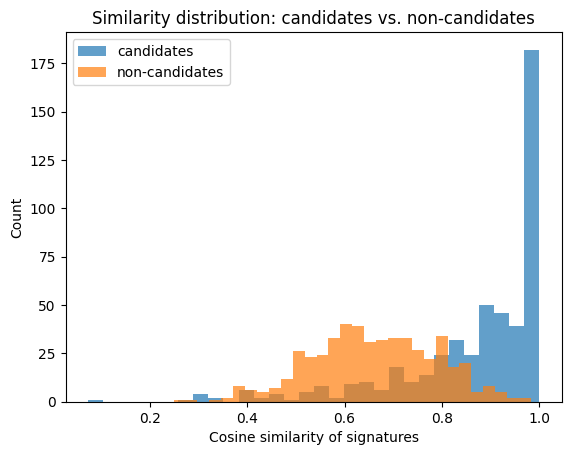

In [ ]:
import random
from itertools import combinations

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# take 500 random candidate pairs and 500 random non‑candidates
candidates = set(cand_pairs)
cand_sample = random.sample(list(candidates), min(500, len(candidates)))
all_pairs = set(combinations(range(len(sentences)), 2))
non_cand = random.sample(list(all_pairs - candidates), 500)


def sig_cos(i, j):
    return cosine_similarity([signatures[i]], [signatures[j]])[0, 0]


cand_sims = [sig_cos(i, j) for i, j in cand_sample]
non_sims = [sig_cos(i, j) for i, j in non_cand]

plt.figure()
plt.hist(cand_sims, bins=30, alpha=0.7, label="candidates")
plt.hist(non_sims, bins=30, alpha=0.7, label="non-candidates")
plt.xlabel("Cosine similarity of signatures")
plt.ylabel("Count")
plt.legend()
plt.title("Similarity distribution: candidates vs. non-candidates")
plt.show()

## **Tuning** the Bands and Similarity Threshold <a name="Optimising-Bands"></a>

The probability that two signatures with similarity $s$ are flagged as a candidate is:

$$ P(\text{candidate}) = 1 - \left(1 - s^{\,r}\right)^{\!b} $$

where $b$ = number of bands, $r$ = rows per band (`n_hashes / b`).

We will re‑run the previous code with different number of **bands** $b$:

- **Increase $b$** –&gt; higher recall (more candidates) but more false positives.
- **Decrease $b$** –&gt; higher precision but risk missing true matches.

Try plotting this curve for several $b$ values and choose the operating point that balances compute budget and accuracy for your project.


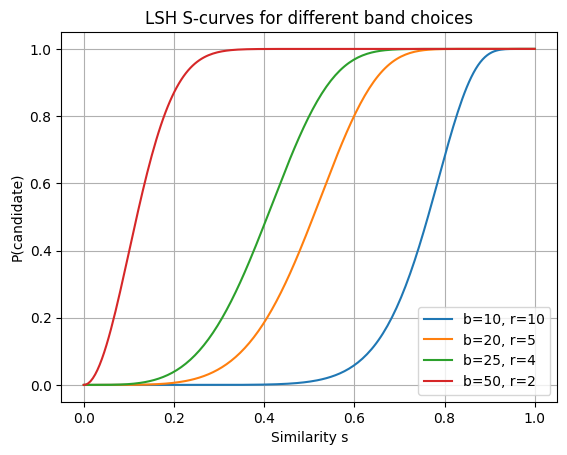

In [ ]:
import matplotlib.pyplot as plt

s_vals = np.linspace(0, 1, 200)


def prob_candidate(s, b, r):
    return 1 - (1 - s**r) ** b


plt.figure()
for b in (10, 20, 25, 50):
    r = n_hashes // b
    plt.plot(s_vals, prob_candidate(s_vals, b, r), label=f"b={b}, r={r}")
plt.xlabel("Similarity s")
plt.ylabel("P(candidate)")
plt.title("LSH S-curves for different band choices")
plt.legend()
plt.grid(True)
plt.show()

### How to Choose number of bands $b$?

**Fewer bands (low b)** mean each band is larger, so only very similar items collide. That increases precision—you’ll filter out most noise—but you may miss some legitimate matches (lower recall).

When choosing **more bands (high b)**, each band is small, so even lightly similar items are likely to share a band. This boosts recall—you’ll catch almost every true match—but you’ll also get more false alarms (lower precision) and more candidate pairs to check.


| Band Choice | Characteristic                         | Precision | Recall | Candidate Count | Possible Use Cases                                                                                            |
| ----------- | -------------------------------------- | --------- | ------ | --------------- | ------------------------------------------------------------------------------------------------------------- |
| **Lower $b$**   | Fewer, larger bands (large r per band) | Higher    | Lower  | Fewer           | – Exact‐match lookups<br>– High‐precision deduplication<br>– Real‑time systems with tight latency constraints |
| **Higher $b$**  | More, smaller bands (small r per band) | Lower     | Higher | More            | – Similar text detection<br>– Plagiarism scan<br>– Broad similarity search where missing matches is costly  |

**Recommendation**: use low b when you need precise matching and only care about strong similarities. Use high b when you can afford extra checks and want to find even weak similarities.

### Method A: Precision and Recall

One way to evaluate LSH performance is to compute the precision and recall of the candidate pairs against the pairs with a high cosine similarity.

Generally:

1. **More bands and fewer rows per band:** More buckets and shorter bands increase chances of items colliding in the same bucket, thus `Recall ↑` but may have `Precision ↓`.

2. **Fewer bands:** `Precision ↑` but may have `Recall ↓`.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score
import random
from itertools import combinations
import pandas as pd

# Define threshold for 'true' similar pairs
s0 = 0.8
bs = [10, 20, 25, 50, 100]

# Sample a manageable subset of all possible document pairs
random.seed(42)  # For reproducibility
all_pairs = list(combinations(range(len(signatures)), 2))
sample_pairs = random.sample(all_pairs, min(20000, len(all_pairs)))

# Cosine similarity between two MinHash signatures
def sig_cos(i, j):
    return cosine_similarity([signatures[i]], [signatures[j]])[0, 0]

# True positive label if signature similarity >= s0
y_true = [sig_cos(i, j) >= s0 for i, j in sample_pairs]


# Evaluation: precision, recall, and candidate count for each band choice
def evaluate_band(b):
    r = n_hashes // b
    lsh_temp = LSH(n_bands=b)
    for idx, sig in enumerate(signatures):
        lsh_temp.add(idx, sig)
    cand_set = set(lsh_temp.candidates())

    # Predicted positive if in candidate set (order-independent)
    y_pred = [((i, j) in cand_set) or ((j, i) in cand_set) for i, j in sample_pairs]

    # Compute precision and recall
    tp = sum(t and p for t, p in zip(y_true, y_pred))
    fp = sum((not t) and p for t, p in zip(y_true, y_pred))
    fn = sum(t and not p for t, p in zip(y_true, y_pred))
    print(f"Band {b}: TP={tp}, FP={fp}, FN={fn}")

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return precision, recall, len(cand_set)


results = []
for b in bs:
    prec, rec, num_cand = evaluate_band(b)
    results.append((b, n_hashes // b, prec, rec, num_cand))

# Create a DataFrame summarizing the results
results_df = pd.DataFrame(
    results, columns=["bands", "rows", "precision", "recall", "num_candidates"]
)

results_df

Band 10: TP=3, FP=1, FN=3486
Band 20: TP=8, FP=2, FN=3481
Band 25: TP=10, FP=9, FN=3479
Band 50: TP=57, FP=223, FN=3432
Band 100: TP=390, FP=2047, FN=3099


,bands,rows,precision,recall,num_candidates
0,10,10,0.750000,0.000860,2715
1,20,5,0.800000,0.002293,5850
2,25,4,0.526316,0.002866,10453
3,50,2,0.203571,0.016337,141003
4,100,1,0.160033,0.111780,1207909


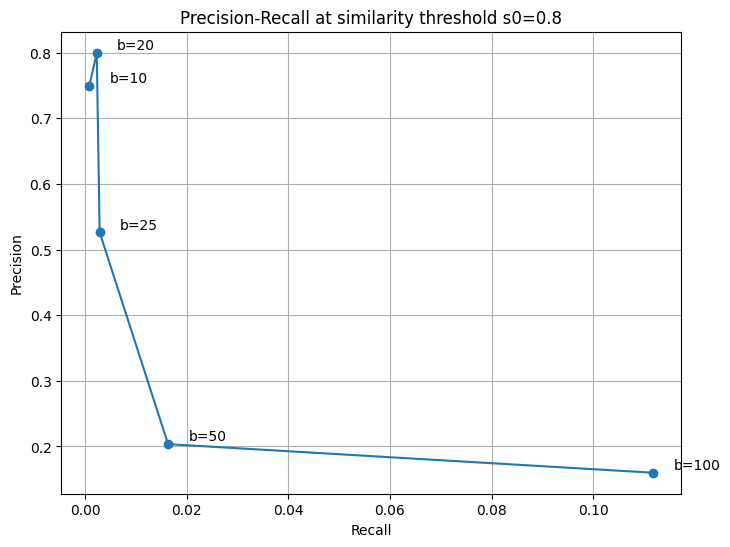

In [ ]:
# Plot precision-recall tradeoff
plt.figure(figsize=(8, 6))
plt.plot(results_df["recall"], results_df["precision"], marker="o")
for _, row in results_df.iterrows():
    plt.text(row["recall"] + 0.004, row["precision"] + 0.005, f"b={int(row['bands'])}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall at similarity threshold s0={s0}")
plt.grid(True)
plt.show()

#### Interpretation

The precision-recall curve shows the trade-off between precision and recall for different band choices. Lower bands tend to have higher precision but lower recall, while higher bands have the opposite effect.

But generally, we have recall under 0.13 for all band choices. This means that even with the best band choice, we are only able to retrieve 13% of the truly similar pairs.

We might be able to improve this by tuning the number of hashing algorithms, but the fundamental limitation is that LSH is an approximate method and cannot guarantee to find all similar pairs.

### Method B: Theoretical vs. Actual

Alternatively, we overlay the theoretical LSH S-curve against actual candidate flags for each $b$.

These plots show how well the binary candidate outcomes match the cosine similarity scores, and intuitively tell us how we should choose $b$ to approximate the desired similarity threshold $s_0$ (usually the cosine similarity threshold).

<img src="./assets/lsh_curve.webp" width="800">

Generally, increasing $b$ (shifting left) increases false positives (FP) while decreasing false negatives (FN), and vice versa.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


def plot_lsh_curve(sim_scores, is_candidate, b, r):
    """Prettified plot: LSH S-curve vs. actual candidate flags."""
    # Sort for smooth curve
    sorted_pairs = sorted(zip(sim_scores, is_candidate))
    x_vals, y_vals = zip(*sorted_pairs)

    # Plot
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Scatter actual candidate labels
    ax1.scatter(x_vals, y_vals, alpha=0.4, color="dodgerblue", s=40, label="Text Pair")
    ax1.set_xlabel("Similarity (s)", fontsize=12)
    ax1.set_ylabel("Is candidate?", fontsize=12)
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(["False", "True"])
    ax1.tick_params(axis="y")
    ax1.grid(True, linestyle="--", alpha=0.3)

    # Theoretical LSH probability curve
    ax2 = ax1.twinx()
    s_curve = np.linspace(0, 1, 300)
    p_curve = 1 - (1 - s_curve**r) ** b
    ax2.plot(
        s_curve, p_curve, linewidth=3, alpha=0.7, label="Theoretical P (candidate)"
    )
    ax2.set_ylabel("Theoretical Probability (P)", fontsize=12)
    ax2.tick_params(axis="y")

    # Title and layout
    plt.title(
        f"LSH S-Curve vs. Candidate Flags (b={b}, r={r})", fontsize=14, weight="bold"
    )
    fig.tight_layout()

    # Add legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left")

    plt.show()

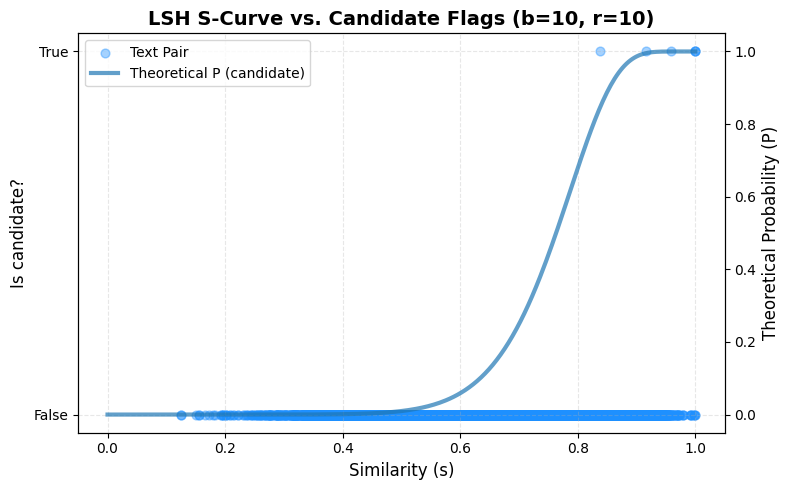

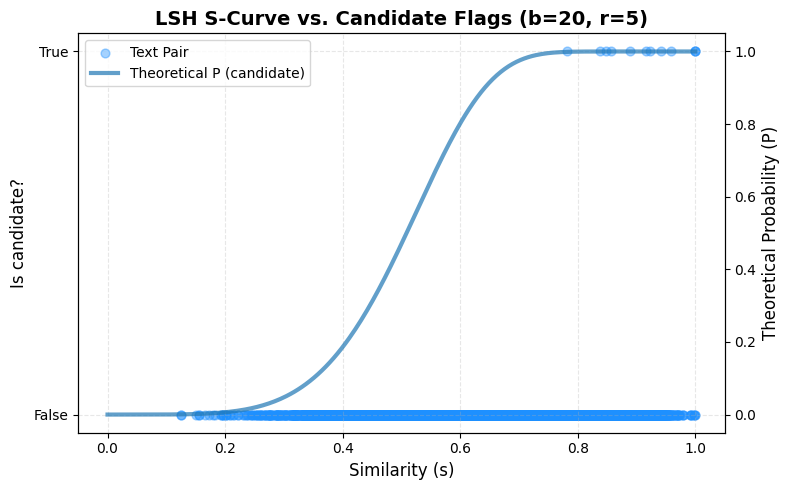

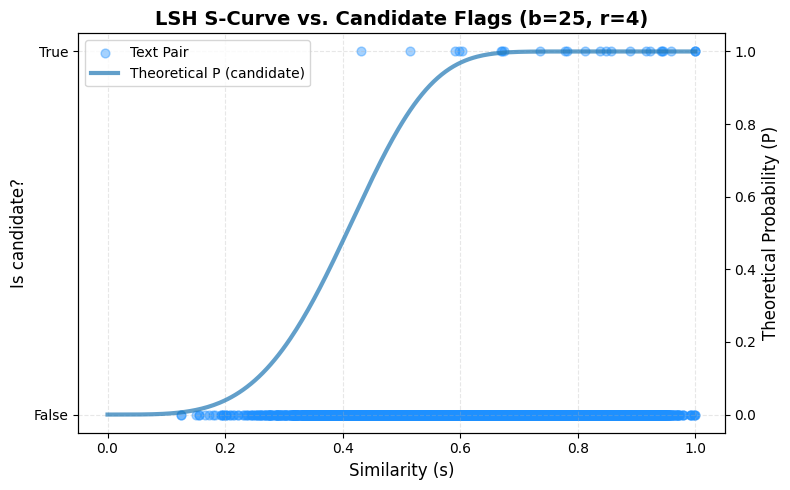

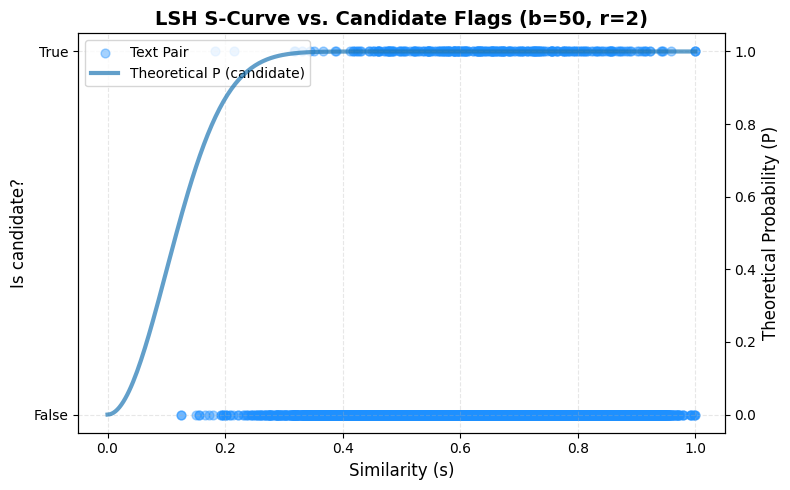

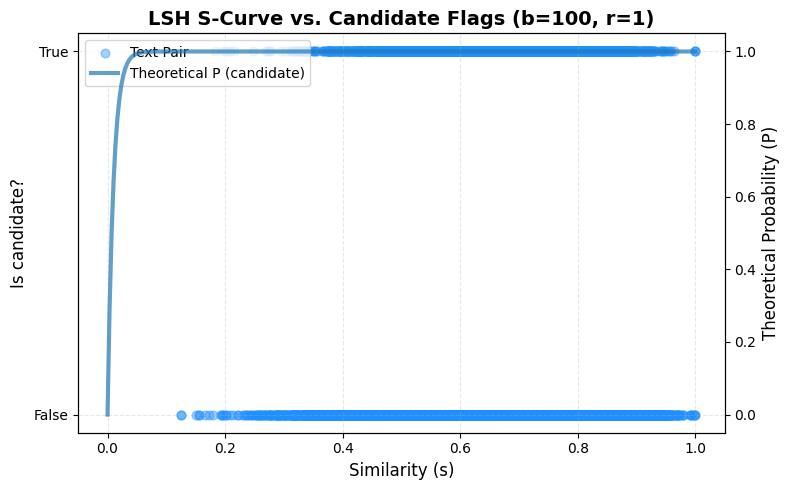

In [ ]:
bs = [10, 20, 25, 50, 100]

all_pairs = list(combinations(range(len(signatures)), 2))
sample_pairs = random.sample(all_pairs, min(20000, len(all_pairs)))

# Compute similarity
sim_scores = []
for i, j in sample_pairs:
    sim = cosine_similarity([signatures[i]], [signatures[j]])[0, 0]
    sim_scores.append(sim)

# Evaluate LSH for each band choice
for b in bs:
    r = n_hashes // b
    lsh_temp = LSH(n_bands=b)
    for idx, sig in enumerate(signatures):
        lsh_temp.add(idx, sig)
    cand_set = set(lsh_temp.candidates())

    # Check if each sample pair is a candidate
    is_candidate = []
    for i, j in sample_pairs:
        is_candidate.append(1 if (i, j) in cand_set or (j, i) in cand_set else 0)

    # Plot the LSH S-curve against actual candidates
    plot_lsh_curve(sim_scores, is_candidate, b, r)

#### **Interpretation**

The plots for each band choice show the theoretical S-curve of LSH candidates against the actual cosine similarity scores.

It reveals a similar pattern found with the precision-recall experiment: lower bands have higher precision but lower recall, while higher bands have the opposite effect.

It also informs us how to choose the number of bands $b$ to approximate the desired similarity threshold $s_0$. For example, **if a cosine similarity threshold of 0.8 is desired, we can choose a band count $b = 10$, according to the first plot.**

However, we also notice that many pairs with a cosine similarity above 0.8 are not flagged as candidates, indicating that LSH is missing some true positives.

## Further Reading <a name="Further-Resources"></a>

- Pinecone blog:
  - [Locality Sensitive Hashing – The Illustrated Guide](https://www.pinecone.io/learn/locality-sensitive-hashing/)
  - [Pinecone & Faiss notebooks on GitHub](https://github.com/pinecone-io/examples)

- [Mining of Massive Datasets (Chapter 3) — S. Ullman et al.](http://mmds.org/#ver30)
